In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pygit2 import Repository
import time
from dotenv import load_dotenv
import mlflow

load_dotenv()

True

# Определение директорий

In [2]:
test_mask_dir = "../data/processed/test/mask/"
test_img_dir = "../data/processed/test/img/"

train_dir = "../data/processed/train/"
val_dir = "../data/processed/validation/"
test_dir = "../data/processed/test/"

# Первый вариант генератора данных

## Генератор чтения масок

In [3]:
def MaskGenerator(directory, batch_size=1):
    i = 0
    files = sorted(os.listdir(directory))
    n_files = len(files)
    mask_batch = np.zeros([batch_size, 200, 2048, 1])
    while 1:
        for j in range(batch_size):
            
            mask = np.fromfile(os.path.join(directory,files[(i+j) % n_files]), dtype=np.ubyte)
            mask_batch[j, :, :, :] = mask.reshape([1, 200, 2048, 1])
            
        i += batch_size
        i = i % n_files
        
        yield mask_batch

## Совместный генератор чтения изображений и масок

Образцы данного генератора для тренировочных и валидационных данных с указанным размером батча подается на нейронную сеть при обучении.

In [4]:
def ImgMaskGenerator(directory, batch_size):

    mask_generator = MaskGenerator(directory=os.path.join(directory, 'mask'),
                                   batch_size=batch_size)
    
    img_datagen = ImageDataGenerator(rescale=1./255)
    
    img_generator = img_datagen.flow_from_directory(directory,
                                             class_mode=None,
                                             target_size=(200, 2048),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             )
    
    train_generator = zip(img_generator, mask_generator)
    
    return train_generator

## Пример генератора

In [5]:
train_generator = ImgMaskGenerator(directory=train_dir,
                                   batch_size=1)

Found 27479 images belonging to 3 classes.


In [6]:
train_generator

## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(1, 200, 2048, 3)
(1, 200, 2048, 1)


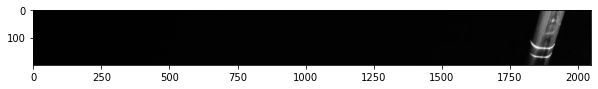

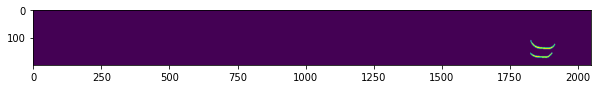

In [7]:
a = next(train_generator)

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(10,10))
plt.imshow(a[0][0,:,:,:])

plt.figure(figsize=(10,10))
plt.imshow(a[1][0,:,:,:])

# Второй вариант генератора данных

## Формирование массивов с путями к файлам

In [8]:
def data_list_dir(directory: str) ->list:
    """
    Create sorted list of files in directory
    :param directory: input directory
    :return: list_dir
    """
    
    dir_list = sorted([os.path.join(directory, fname)
                       for fname in os.listdir(directory)])
    
    return dir_list

In [9]:
train_img_dir = os.path.join(train_dir, 'img')
images = data_list_dir(train_img_dir)

train_mask_dir = os.path.join(train_dir, 'mask')
masks = data_list_dir(train_mask_dir)

print("Number of samples:", len(images), len(masks))
for train_img_dir, train_mask_dir in zip(images[:10], masks[:10]):
    print(train_img_dir[-33:], "|", train_mask_dir[-34:])
    
print('Количество изображений:', len(images))

Number of samples: 27479 27479
210416D.003_1400701D.E003_0_0.jpg | 210416D.003_1400701D.E003_0_0.mask
210416D.003_1400701D.E003_0_1.jpg | 210416D.003_1400701D.E003_0_1.mask
6D.003_1400701D.E003_100000_1.jpg | 6D.003_1400701D.E003_100000_1.mask
6D.003_1400701D.E003_100005_1.jpg | 6D.003_1400701D.E003_100005_1.mask
16D.003_1400701D.E003_10000_1.jpg | 16D.003_1400701D.E003_10000_1.mask
6D.003_1400701D.E003_100010_1.jpg | 6D.003_1400701D.E003_100010_1.mask
6D.003_1400701D.E003_100015_1.jpg | 6D.003_1400701D.E003_100015_1.mask
6D.003_1400701D.E003_100020_1.jpg | 6D.003_1400701D.E003_100020_1.mask
6D.003_1400701D.E003_100025_1.jpg | 6D.003_1400701D.E003_100025_1.mask
6D.003_1400701D.E003_100030_1.jpg | 6D.003_1400701D.E003_100030_1.mask
Количество изображений: 27479


## Функции чтения изображения маски, выходные данные - TF тензор

In [10]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 1024
CHANNELS = 3


def read_data_img(file_path, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    data = tf.image.decode_png(data, channels=CHANNELS)
    data.set_shape([None, None, CHANNELS])
    data = tf.image.resize(images=data, size=[height, width])
    data = data / 255.
    
    return data

def read_data_mask(file_path, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    data = tf.io.decode_raw(data, tf.int8)
    data = tf.reshape(data, [200, 2048,1])
    data = tf.image.resize(images=data, size=[height, width])
    
    return data

## Совместный генератор чтения изображений и масок

In [11]:
def load_data(image_list, mask_list):
    image = read_data_img(image_list)
    mask  = read_data_mask(mask_list)
    return image, mask


def img_mask_generator(directory, split='train', batch_size=1):
    
    image_list = data_list_dir(os.path.join(directory,'img'))
    mask_list = data_list_dir(os.path.join(directory,'mask'))
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(8*batch_size) if split == 'train' else dataset 
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

## Пример генератора

In [12]:
train_datagen = img_mask_generator(train_dir, batch_size=16)
val_datagen = img_mask_generator(val_dir, batch_size=16)

In [13]:
print(train_datagen)

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 128, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 128, 1024, 1), dtype=tf.float32, name=None))>


## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(16, 128, 1024, 3)
(16, 128, 1024, 1)


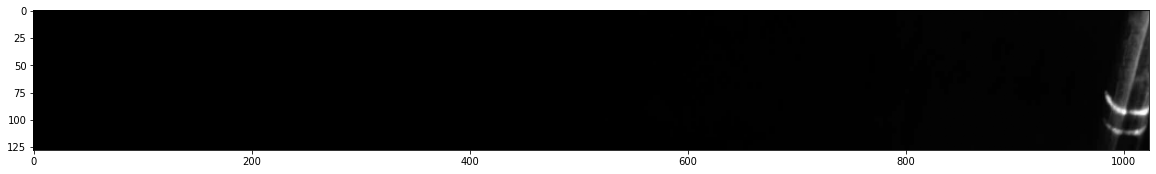

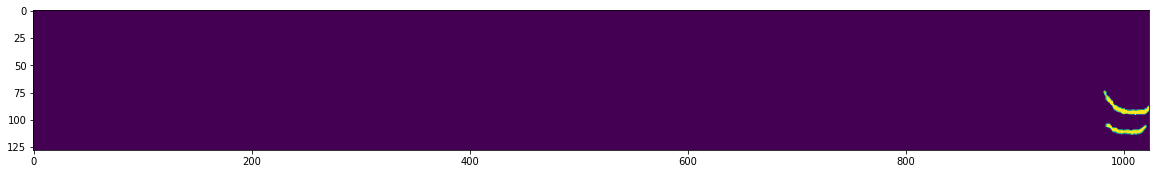

In [14]:
a = next(iter(val_datagen.take(1)))

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(20,10))
plt.imshow(a[0][1,:,:,:])

plt.figure(figsize=(20,10))
plt.imshow(a[1][1,:,:,:])

# Нейронная сеть

In [15]:
import matplotlib.pyplot as plt 

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

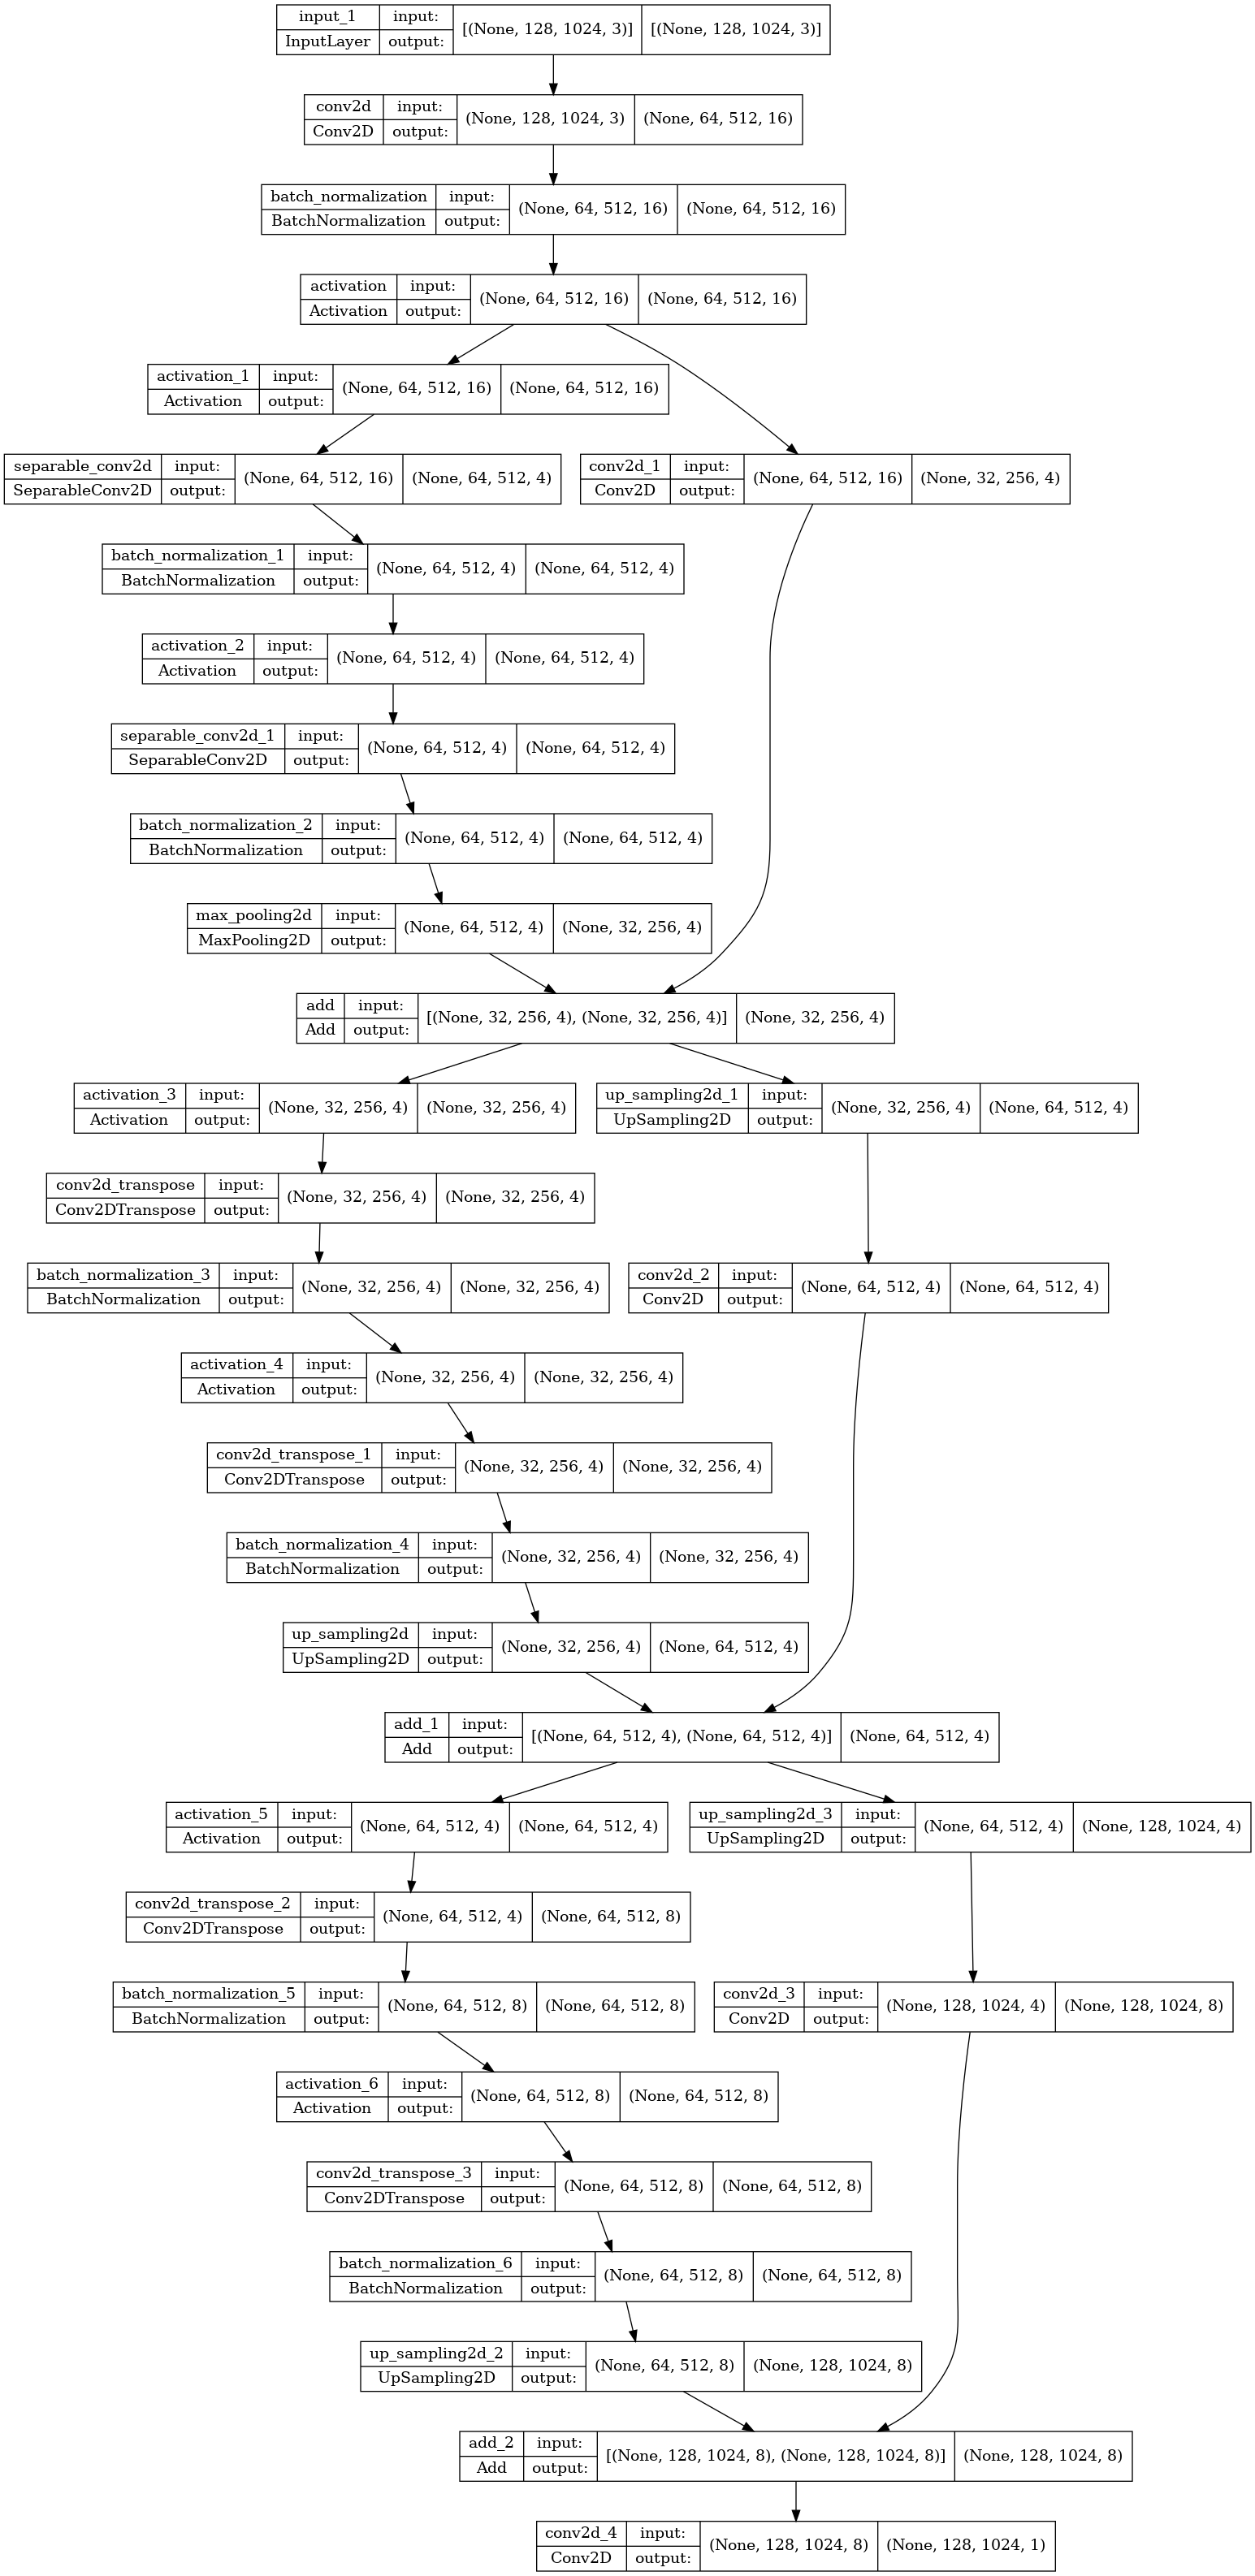

In [16]:
from tensorflow import keras 
from tensorflow.keras import layers

# https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (CHANNELS,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [4]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [4, 8]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
# define optomizer
optim = keras.optimizers.Adam(0.001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=1):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(20, 20))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10
200/200 [==============================] - 21s 86ms/step - loss: 0.0929 - accuracy: 0.9824 - val_loss: 0.0263 - val_accuracy: 0.9952
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9972

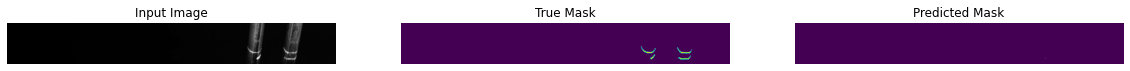


Sample Prediction after epoch 2

200/200 [==============================] - 18s 88ms/step - loss: 0.0063 - accuracy: 0.9972 - val_loss: 0.0173 - val_accuracy: 0.9953
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9974

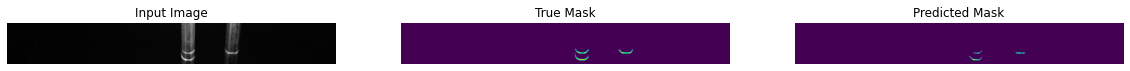


Sample Prediction after epoch 3

200/200 [==============================] - 17s 83ms/step - loss: 0.0049 - accuracy: 0.9974 - val_loss: 0.0074 - val_accuracy: 0.9967
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9975

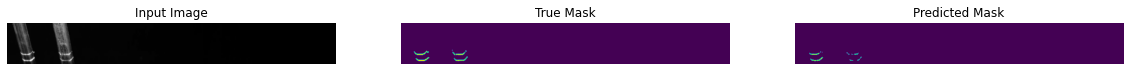


Sample Prediction after epoch 4

200/200 [==============================] - 17s 83ms/step - loss: 0.0042 - accuracy: 0.9975 - val_loss: 0.0053 - val_accuracy: 0.9972
Epoch 5/10
200/200 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9975

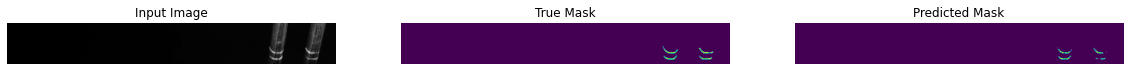


Sample Prediction after epoch 5

200/200 [==============================] - 17s 83ms/step - loss: 0.0039 - accuracy: 0.9975 - val_loss: 0.0041 - val_accuracy: 0.9975
Epoch 6/10
200/200 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9976

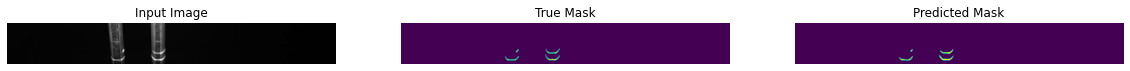


Sample Prediction after epoch 6

200/200 [==============================] - 17s 83ms/step - loss: 0.0037 - accuracy: 0.9976 - val_loss: 0.0040 - val_accuracy: 0.9976
Epoch 7/10
200/200 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9975

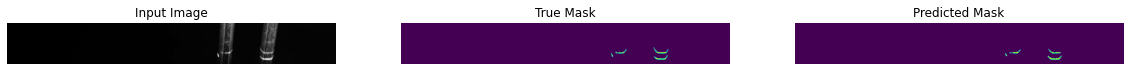


Sample Prediction after epoch 7

200/200 [==============================] - 17s 83ms/step - loss: 0.0037 - accuracy: 0.9975 - val_loss: 0.0036 - val_accuracy: 0.9976
Epoch 8/10
200/200 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9976

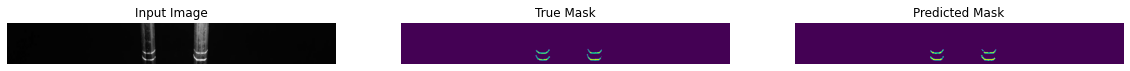


Sample Prediction after epoch 8

200/200 [==============================] - 17s 83ms/step - loss: 0.0037 - accuracy: 0.9976 - val_loss: 0.0037 - val_accuracy: 0.9976
Epoch 9/10
117/200 [================>.............] - ETA: 6s - loss: 0.0038 - accuracy: 0.9976WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


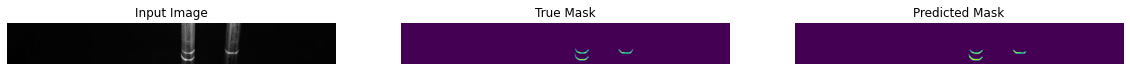


Sample Prediction after epoch 9

200/200 [==============================] - 10s 50ms/step - loss: 0.0038 - accuracy: 0.9976 - val_loss: 0.0037 - val_accuracy: 0.9976
INFO:tensorflow:Assets written to: /tmp/tmp_yitkpyh/model/data/model/assets


In [19]:


mlflow.set_tracking_uri('http://localhost:5000')
mlflow.tensorflow.autolog()
mlflow.set_experiment(experiment_name=Repository('.').head.shorthand)

with mlflow.start_run():
    epochs = 10
    model.fit(
        train_datagen,
        steps_per_epoch=200,
        epochs=epochs,
        validation_data=val_datagen,
        validation_steps=20,
        callbacks=[DisplayCallback(train_datagen)]
    )
    
    
    time_of_prediction_array = np.zeros(100)
    
    test_image_path = '../data/processed/test/img/210416D.003_1400701D.E003_96860_2.jpg'
    test_img = read_data_img(test_image_path)
    test_img = tf.reshape(test_img, [1, 128, 1024, CHANNELS])
    
    for i in range(100):
        
        start = time.perf_counter()
        mask = model.predict(test_img)
        end = time.perf_counter()
        
        time_of_prediction_array[i] = end - start
        
    speed_metrics = {'pred_time': time_of_prediction_array[1:].mean(),
                     'RMSE_pred_time': time_of_prediction_array[1:].std() }    
    mlflow.log_metrics(speed_metrics)

In [20]:
test_image_path = '../data/processed/test/img/210416D.003_1400701D.E003_96860_2.jpg'
test_img = read_data_img(test_image_path)
test_img = tf.reshape(test_img, [1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS])

In [21]:

start = time.perf_counter()
mask = model.predict(test_img)
end = time.perf_counter()
print(end-start)

0.028820052000014584


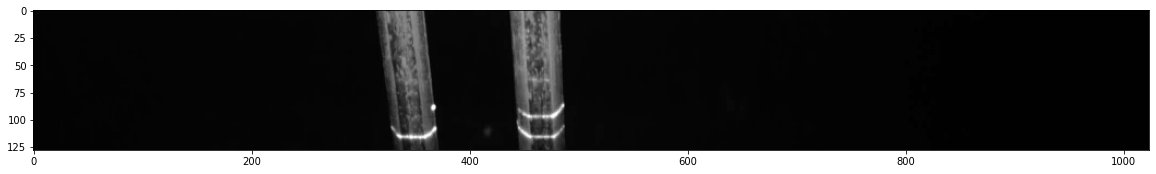

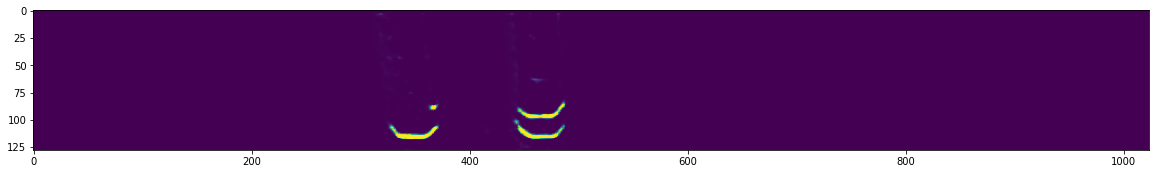

In [22]:

plt.figure(figsize=(20, 10))
plt.imshow(test_img[0])
plt.figure(figsize=(20, 10))
plt.imshow(mask[0])

In [23]:
time_of_prediction_array

array([0.10804603, 0.02323216, 0.02175717, 0.02204309, 0.02225635,
       0.02161702, 0.02166332, 0.02159211, 0.02704917, 0.02200099,
       0.02234224, 0.02145834, 0.02192151, 0.02163125, 0.0218101 ,
       0.02158506, 0.02164939, 0.0211463 , 0.02680698, 0.02239278,
       0.02188998, 0.02235841, 0.02128098, 0.02116812, 0.02111483,
       0.02059936, 0.02092673, 0.02062261, 0.0268349 , 0.02205963,
       0.02148588, 0.02167483, 0.02177136, 0.02088418, 0.02096577,
       0.02068921, 0.02151244, 0.02821633, 0.02139066, 0.02136147,
       0.02192082, 0.02117813, 0.0215851 , 0.02094418, 0.02107157,
       0.02082912, 0.02112307, 0.02610322, 0.02164924, 0.02137768,
       0.02148828, 0.02157386, 0.0209267 , 0.02071737, 0.02067649,
       0.02056145, 0.02134312, 0.02644816, 0.02212399, 0.02177433,
       0.02142822, 0.02087519, 0.02075718, 0.02129782, 0.02084188,
       0.02017584, 0.02523304, 0.02180673, 0.02343159, 0.02214633,
       0.0209797 , 0.02105028, 0.02162357, 0.02093141, 0.02112

In [24]:
for i in []:
    print('1')